##### STEP 1: Load Dataset

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

df = pd.read_csv('../data/TSLA_Stock.csv')
df.head(5)

,ID,Date,Close,High,Low,Open,Volume
0,2701,03/23/2021,220.720001,225.933334,219.169998,225.256668,91475700
1,2702,03/24/2021,210.089996,222.673340,210.036667,222.636673,101385600
2,2703,03/25/2021,213.463333,215.166672,203.166672,204.333328,117674700
3,2704,03/26/2021,206.236664,214.606674,199.963333,213.956665,101558400
4,2705,03/29/2021,203.763336,205.493332,198.673340,205.213333,85911000


STEP 2: Understand Dataset

In [9]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      254 non-null    int64  
 1   Date    254 non-null    object 
 2   Close   254 non-null    float64
 3   High    254 non-null    float64
 4   Low     254 non-null    float64
 5   Open    254 non-null    float64
 6   Volume  254 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 14.0+ KB


,ID,Close,High,Low,Open,Volume
count,254.00000,254.000000,254.000000,254.000000,254.000000,2.540000e+02
mean,2827.50000,271.162716,277.073674,264.883254,271.057625,7.689703e+07
std,73.46768,57.321652,59.656889,54.854340,57.529603,2.764321e+07
min,2701.00000,187.820007,188.736664,182.326660,184.183334,2.940180e+07
25%,2764.25000,224.816673,229.460003,222.467503,225.960007,5.690258e+07
50%,2827.50000,252.746666,254.574997,248.695000,252.025002,7.194180e+07
75%,2890.75000,310.809158,316.795837,302.272507,310.839996,9.173018e+07
max,2954.00000,409.970001,414.496674,405.666656,411.470001,1.885563e+08


##### STEP 3: Fix Date

In [10]:
# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort by date
df = df.sort_values("Date")

# Reset index
df = df.reset_index(drop=True)

# Check
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ID      254 non-null    int64         
 1   Date    254 non-null    datetime64[ns]
 2   Close   254 non-null    float64       
 3   High    254 non-null    float64       
 4   Low     254 non-null    float64       
 5   Open    254 non-null    float64       
 6   Volume  254 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 14.0 KB


##### STEP 5: import seaborn as sns

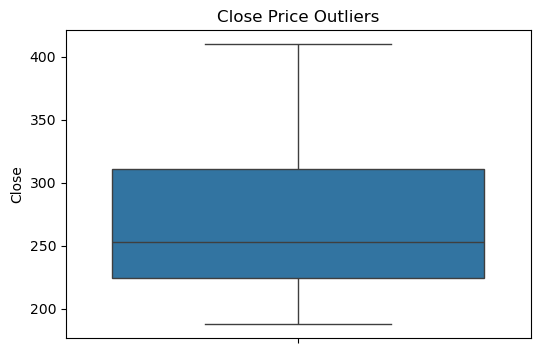

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df["Close"])
plt.title("Close Price Outliers")
plt.show()

##### STEP 4: EDA

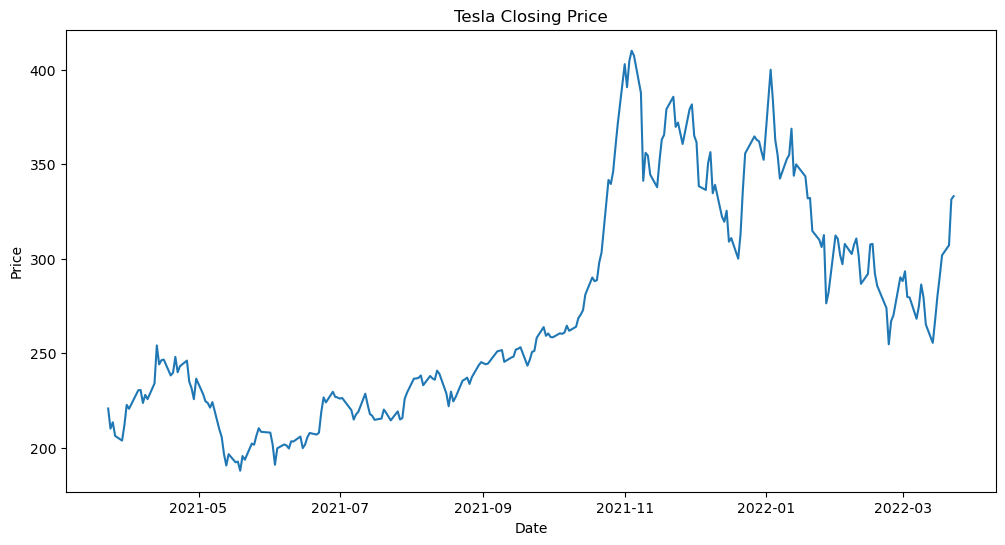

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"])
plt.title("Tesla Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

##### STEP 5: Feature Engineering

In [24]:
# Create a new column for daily change. so we can see how much the stock price changed each day.
df["Daily_Change"] = df["Close"] - df["Open"]
df["High_Low_Diff"] = df["High"] - df["Low"]
df["Pct_Change"] = (df["Close"] - df["Open"]) / df["Open"] * 100
df['Target_Close'] = df['Close'].shift(-1)

In [14]:
# Calculate moving averages
df["MA_5"] = df["Close"].rolling(5).mean()
df["MA_10"] = df["Close"].rolling(10).mean()

##### Step 6: Handling Missing values

In [ ]:
df.isnull().sum()
# MA_5 and MA_10 will have NaN values for the first few rows because there aren't enough previous days to calculate the average. We can drop these rows for now.
df = df.dropna()

ID               0
Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Daily_Change     0
High_Low_Diff    0
Pct_Change       0
MA_5             0
MA_10            0
Target_Close     0
dtype: int64

##### STEP 7: Select X and y

In [16]:
X = df[[
    "Open",
    "High",
    "Low",
    "Volume",
    "Daily_Change",
    "High_Low_Diff",
    "MA_5",
    "MA_10",
    "Pct_Change"
]]

y = df["Close"]


###### x= input (matrix), where y = output/target (vector)

##### STEP 8: Train-Test Split(Time Series Way)

In [17]:
split = int(len(df)*0.8)


X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]


##### STEP 9: Train Model

In [35]:
# Linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# used model.fit() instead of calculus to train the model on the training data
model.fit(X_train, y_train)

# Save trained model
joblib.dump(model, "../models/tesla_price_model.pkl")

print("Model saved successfully!")

Model saved successfully!


##### Step 10: Evaluate models

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, pred)

print("RMSE:", rmse)
print("R2 Score:", r2)

RMSE: 6.1479402299015326e-09
R2 Score: 1.0


##### Step 11: Add Predcition tomorrow closing

##### Step 1: Create x and y variables

In [29]:
X_future = df[[
    "Open","High","Low","Volume",
    "Daily_Change","High_Low_Diff",
    "MA_5","MA_10","Pct_Change"
]]

y_future = df["Target_Close"]


##### Step 2: Split

In [31]:
from sklearn.model_selection import train_test_split

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_future, y_future,
    test_size=0.2,
    shuffle=False
)

##### Step 3: Train model using Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

future_model = LinearRegression()
future_model.fit(Xf_train, yf_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


##### Step 4: Save New Model

In [34]:
joblib.dump(future_model, "../models/future_price_model.pkl")
print("Future price model saved successfully!")

Future price model saved successfully!
